<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

**Somethings to change**:

1.  find the eigen point correspoing mode, W and PC relation

2.  Make the analysis more stable by using last three weights

3.  Try to find decoding performance in 10-50 setting

4.  Use more range to measure not only 15 55 85

5.  Same trends of increasing img, but failed prediction, what is other factors?  What really predicts the limit cycle type strategy? 

6.  Relation of PC dimension and real trace shape, if too high D will make the real game hard? 

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import pandas as pd

import navigation2
from navigation2 import *

import sklearn
from sklearn.svm import SVC

import scipy
from scipy.spatial import distance
from scipy import signal

import Nets 
from Nets import *

import dynamics
from dynamics import * 



%pylab inline
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


### Qnetwork

To select actions we take maximum of Q value, corresponding to certain move.

For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

##  test Pretrain results
In this game , we use a new reward function determined by game, if the agent achieves the goal before 50, reward is 1. If time pass 50 reward is 0.5, once time pass 100 agent gets a reward of -0.5 .  Practically, this is found to be easier to learn than the rewards as a continous function of time.  Tf the agent learns to search in a efficient way, the largest possible way for search is to firstly arrive at corner then goes to the goal, which, takes about 50 steps, it is reasonble to make 50 and 100 as milestone thing.  Also in principe as the game doesn't have a timer , it is not if it can use a reward as funtion of time

3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

Training from zero seems to be better because it will allow the agent to explore from new

**A coherent result here is threhold kind behaviour of decode vs performance, after decode smaller than 10, the performance rises.  The resutls is showeing that the learning rate vs performance doesn't characterize the threshold kind behaviour of performance change.  It is only after lr = -5, the performance begins to rise , while the learning rate - performance curve creates a fake trends for first few points.  This is not shown by explaination factor calculated by covariance.  **

In [93]:
exp(500)

1.4035922178528375e+217

In [25]:
def placefield_target(pos): 
    field =np.zeros((2, 20 + 4))
    for k in range(2):
        for i in range(field.shape[1]): 
        # distance generation 
            field[k, i] = (i- pos[k]) ** 2 
    # gaussian density, but before exponential to help learning identity mapping input to output
    field = torch.from_numpy(field).resize(1, 2 * (20 + 4)).float()
    return field

In [26]:
Entropy = []
Entropy_ref = []
for iters, trial in enumerate(np.arange(0, 400, 10)):
    beta = 1e-2 
    game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)],  alpha = 0.5, input_type = 0)
    game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)))
    Poss = []
    hs = []
    for i in range(10):
        Pos,h, dh, a, s, reward = trajectory(game, pos0 = (np.random.randint(2, 17), np.random.randint(2, 17)), epsilon=0.5)
        det = np.sum(s[1:]- s[:-1], axis = 1)
        T = np.where(det!=0)
        if len(T[0])>0:
            Poss.extend(Pos[T[0][0]:-1])
            hs.extend(h[T[0][0]:])
    placefield = [placefield_target(pos).data.numpy() for pos in Poss]
    predict = [(torch.from_numpy(h).matmul(game.net.h2p1) + game.net.bp1).data.numpy() for h in hs]
#     print ('mse', np.linalg.norm(np.array(placefield) - np.array(predict)))
    def probs(field):
        prob = np.exp(-beta * field.ravel())/np.sum(np.exp(-beta * field.ravel()))
        return prob
    Prob = np.array([probs(f) for f in placefield])
    Prob_p = np.array([probs(f) for f in predict])
    Entropy.append(-np.mean(Prob * np.log(Prob_p + 1e-5)))
    Entropy_ref.append(-np.mean(Prob * np.log(Prob + 1e-5)))

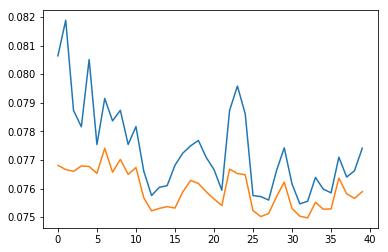

In [27]:
plt.plot(Entropy)
plt.plot(Entropy_ref)

In [32]:
Entropy = []
Entropy_ref = []
for iters, trial in enumerate(np.arange(0, 400, 40)):
    beta = 3 * 1e-2 
    game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)],  alpha = 0.5, input_type = 0)
    game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)))
    Poss = []
    hs = []
    for i in range(10):
        Pos,h, dh, a, s, reward = trajectory(game, pos0 = (np.random.randint(2, 17), np.random.randint(2, 17)), epsilon=0.5)
        det = np.sum(s[1:]- s[:-1], axis = 1)
        T = np.where(det!=0)
        if len(T[0])>0:
            Poss.extend(Pos[T[0][0]:-1])
            hs.extend(h[T[0][0]:])
    placefield = [placefield_target(pos).data.numpy() for pos in Poss]
    predict = [(torch.from_numpy(h).matmul(game.net.h2p2) + game.net.bp2) for h in hs]
#     print ('mse', np.linalg.norm(np.array(placefield) - np.array(predict)))
    def probs(field):
        prob = np.exp(-beta * field.ravel())/np.sum(np.exp(-beta * field.ravel()))
        return prob
    def probs_tensor(field):
        prob = F.softmax(-beta * field.view(-1))
        return prob
    Prob = np.array([probs(f) for f in placefield])
    Prob_p = np.array([probs_tensor(f).data.numpy() for f in predict])
    Entropy.append(-np.mean(Prob * np.log(Prob_p + 1e-5)))
    Entropy_ref.append(-np.mean(Prob * np.log(Prob + 1e-5)))

In [33]:
Prob_p

array([[  1.01685869e-02,   1.42203812e-02,   1.85864642e-02, ...,
          2.11435626e-03,   1.20648078e-03,   6.66594657e-04],
       [  1.24371788e-02,   1.73548758e-02,   2.28470415e-02, ...,
          1.32517234e-04,   7.10228851e-05,   3.58372818e-05],
       [  8.11972748e-03,   1.18534975e-02,   1.64814536e-02, ...,
          5.23211842e-04,   3.28613794e-04,   2.00453520e-04],
       ..., 
       [  1.36225042e-03,   2.55653961e-03,   4.59870463e-03, ...,
          1.59934643e-04,   7.54590656e-05,   3.47122768e-05],
       [  1.55969581e-03,   2.87500792e-03,   5.05704945e-03, ...,
          8.05061136e-05,   3.83550287e-05,   1.77550119e-05],
       [  2.90001114e-03,   5.09651657e-03,   8.44515301e-03, ...,
          6.64350446e-05,   3.21786283e-05,   1.50838914e-05]], dtype=float32)

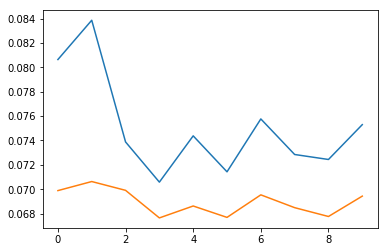

In [34]:
plt.plot(Entropy)
plt.plot(Entropy_ref)

In [21]:
Entropy = []
Entropy_ref = []
for iters, trial in enumerate(np.arange(0, 400, 40)):
    beta = 9 * 1e-2 
    game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.5), (0.5, 0.5)],  alpha = 0.5, input_type = 0)
    game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)))
    Poss = []
    hs = []
    for i in range(10):
        Pos,h, dh, a, s, reward = trajectory(game, pos0 = (np.random.randint(2, 17), np.random.randint(2, 17)), epsilon=0.5)
        det = np.sum(s[1:]- s[:-1], axis = 1)
        T = np.where(det!=0)
        if len(T[0])>0:
            Poss.extend(Pos[T[0][0]:-1])
            hs.extend(h[T[0][0]:])
    placefield = [placefield_target(pos).data.numpy() for pos in Poss]
    predict = [(torch.from_numpy(h).matmul(game.net.h2p3) + game.net.bp3) for h in hs]
#     print ('mse', np.linalg.norm(np.array(placefield) - np.array(predict)))
    def probs(field):
        prob = np.exp(-beta * field.ravel())/np.sum(np.exp(-beta * field.ravel()))
        return prob
    def probs_tensor(field):
        prob = F.softmax(-beta * field.view(-1))
        return prob
    Prob = np.array([probs(f) for f in placefield])
    Prob_p = np.array([probs_tensor(f).data.numpy() for f in predict])
    Entropy.append(-np.mean(Prob * np.log(Prob_p + 1e-5)))
    Entropy_ref.append(-np.mean(Prob * np.log(Prob + 1e-5)))

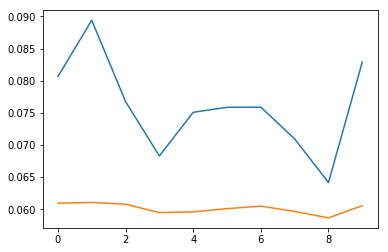

In [22]:
plt.plot(Entropy)
plt.plot(Entropy_ref)

entropy 3.6428
entropy 3.68285
entropy 3.69282
entropy 3.72045
entropy 3.74495
entropy 3.76507
entropy 3.76319
entropy 3.76695
entropy 3.77508
entropy 3.77416
entropy 3.84691
entropy 3.80546
entropy 3.81075
entropy 3.84953
entropy 3.85916
entropy 3.89108
entropy 3.88131
entropy 3.91577
entropy 3.936
entropy 3.84024
entropy 3.85828
entropy 3.83907
entropy 3.85573
entropy 3.85563
entropy 3.9407
entropy 4.00172
entropy 4.05139
entropy 4.13256
entropy 4.13725
entropy 4.11761


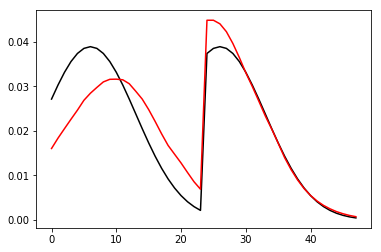

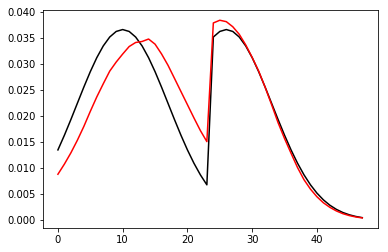

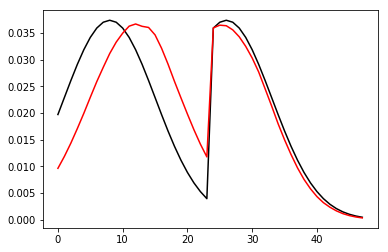

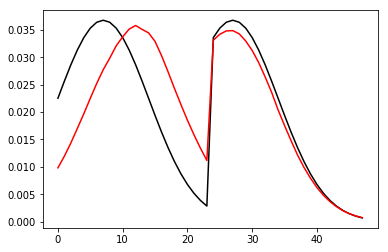

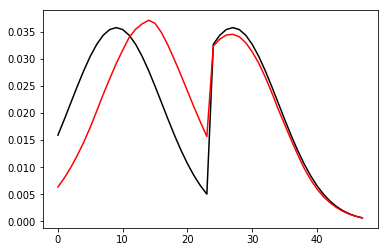

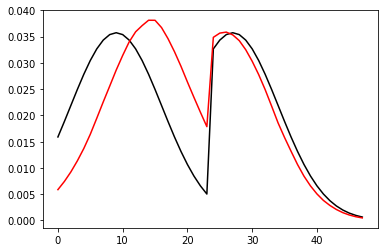

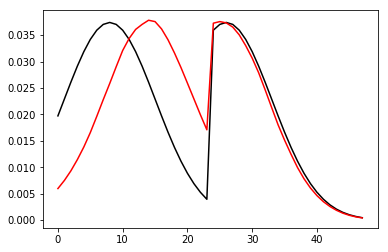

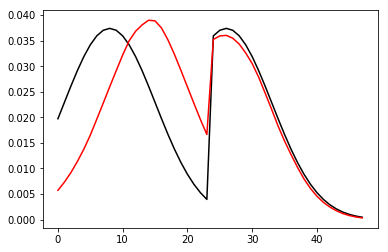

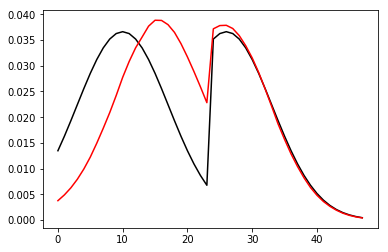

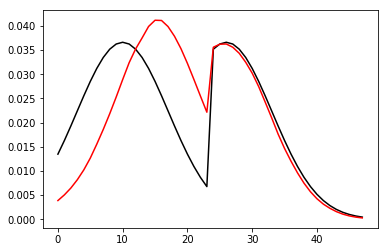

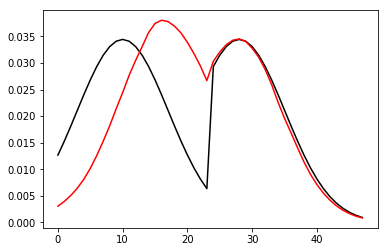

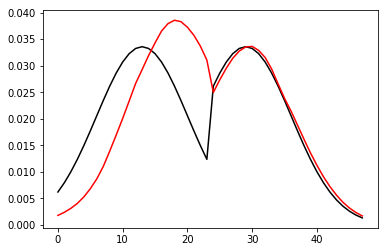

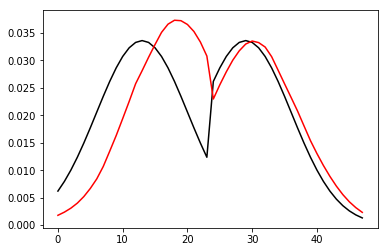

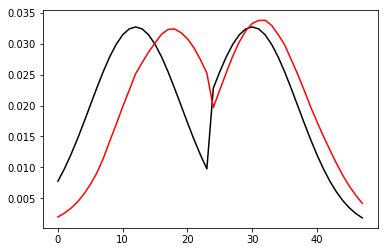

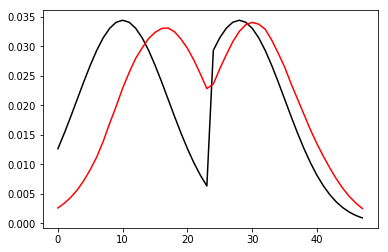

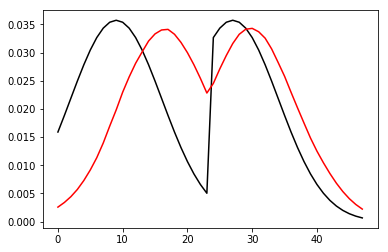

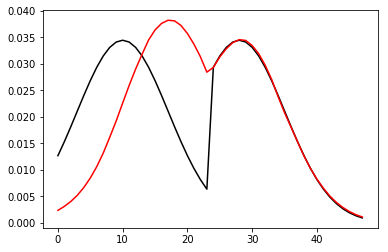

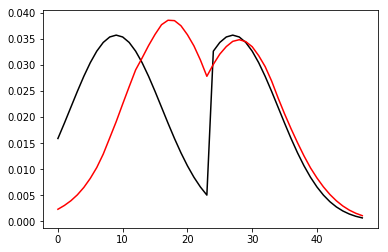

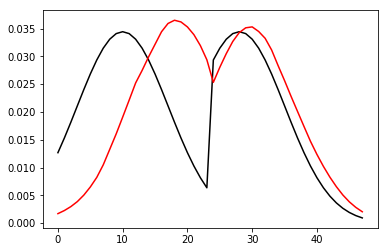

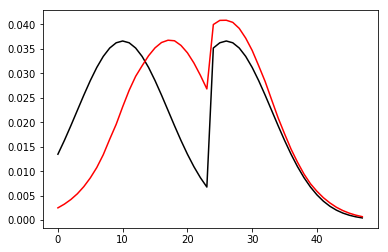

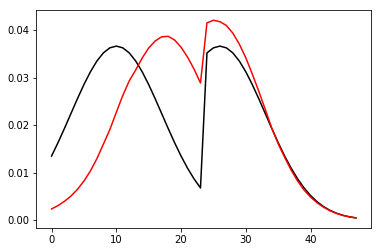

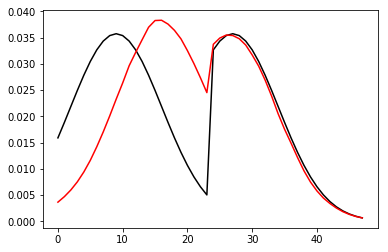

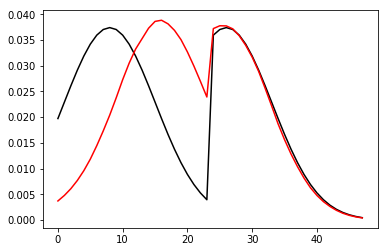

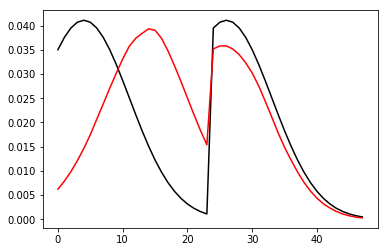

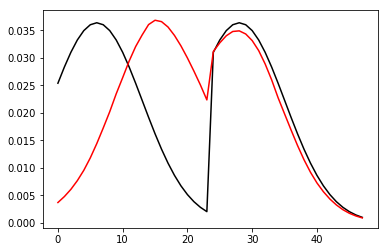

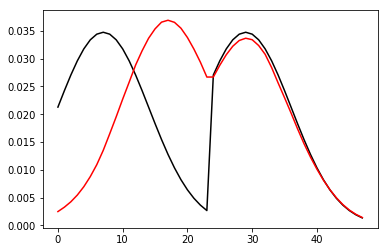

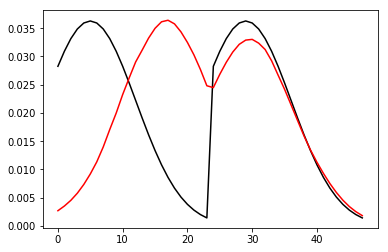

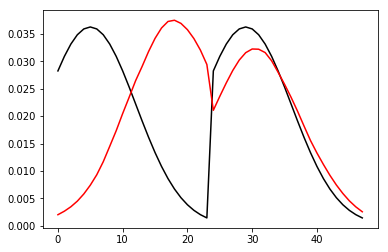

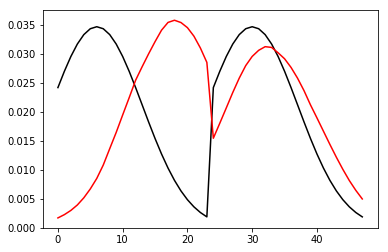

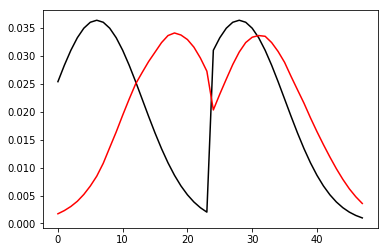

In [4]:
trial = 399
game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.5), (0.5, 0.5)],  alpha = 0.5, input_type = 0)
game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)))
Poss = []
hs = []
for i in range(1):
    Pos,h, dh, a, s, reward = trajectory(game, pos0 = (5, 2), epsilon=1)
    Poss.extend(Pos[:-1])
    hs.extend(h)
    placefield = [placefield_target(pos).data.numpy() for pos in Poss]
    predict = [(torch.from_numpy(h).matmul(game.net.h2p1) + game.net.bp1).data.numpy() for h in hs]
beta = 1e-2
for i in range(30):
    plt.figure()
    prob = np.exp(-beta * placefield[4 * i + 1].ravel())/np.sum(np.exp(-beta * placefield[4 * i + 1].ravel()))
    plt.plot(prob, 'k')
    prob_p = np.exp(-beta * predict[4 * i + 1].ravel())/np.sum(np.exp(-beta * predict[4 * i + 1].ravel()))
    plt.plot(prob_p, 'r')
    print ('entropy', -np.sum(prob * np.log(prob_p + 1e-5)))

entropy 3.28563
entropy nan
entropy nan
entropy nan
entropy nan


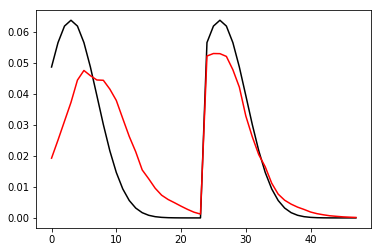

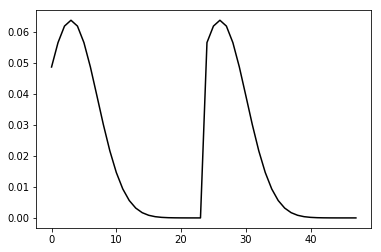

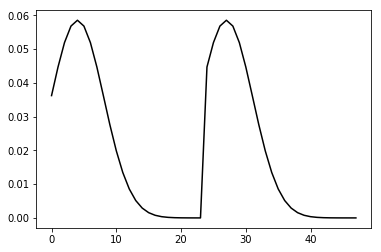

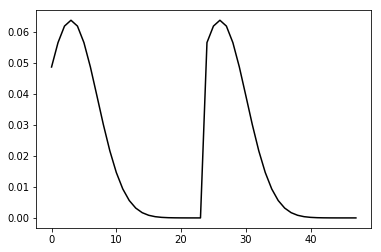

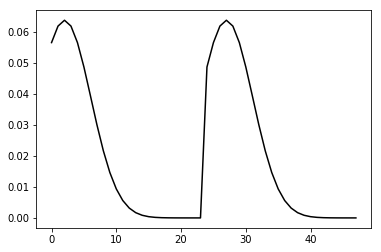

In [6]:
trial = 399
game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.5), (0.5, 0.5)],  alpha = 0.5, input_type = 0)
game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)))
Poss = []
hs = []
for i in range(1):
    Pos,h, dh, a, s, reward = trajectory(game, pos0 = (2, 2), epsilon=1)
    Poss.extend(Pos[:-1])
    hs.extend(h)
    placefield = [placefield_target(pos).data.numpy() for pos in Poss]
    predict = [(torch.from_numpy(h).matmul(game.net.h2p2) + game.net.bp2).data.numpy() for h in hs]
beta = 3 * 1e-2
for i in range(5):
    plt.figure()
    prob = np.exp(-beta * placefield[2 * i + 1].ravel())/np.sum(np.exp(-beta * placefield[2 * i + 1].ravel()))
    plt.plot(prob, 'k')
    prob_p = np.exp(-beta * predict[2 * i + 1].ravel())/np.sum(np.exp(-beta * predict[2 * i + 1].ravel()))
    plt.plot(prob_p, 'r')
    print ('entropy', -np.sum(prob * np.log(prob_p+1e-5)))

entropy nan
entropy nan
entropy nan
entropy nan
entropy nan
entropy nan
entropy nan
entropy nan


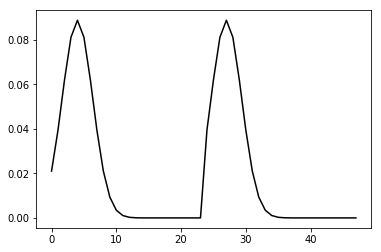

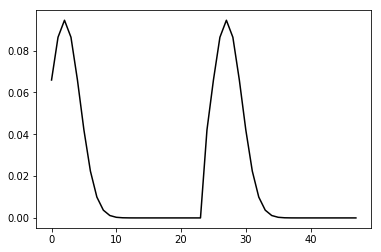

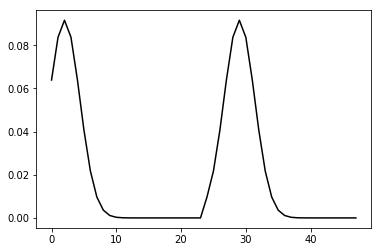

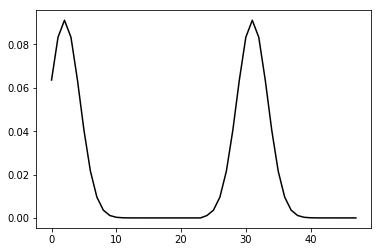

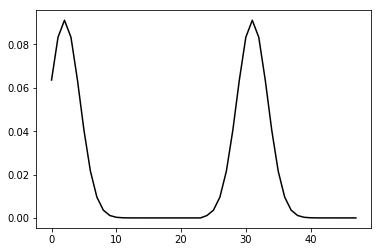

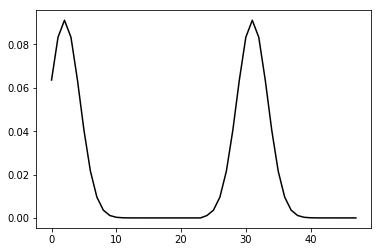

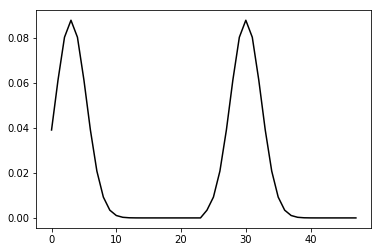

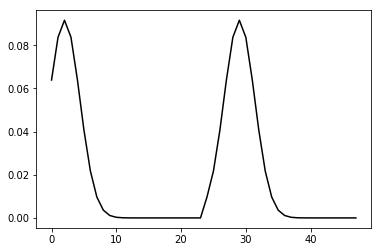

In [97]:
trial = 290
game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)],  alpha = 0.5, input_type = 0)
game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)))
Poss = []
hs = []
for i in range(1):
    Pos,h, dh, a, s, reward = trajectory(game, pos0 = (4, 2), epsilon=1)
    Poss.extend(Pos[:-1])
    hs.extend(h)
    placefield = [placefield_target(pos).data.numpy() for pos in Poss]
    predict = [(torch.from_numpy(h).matmul(game.net.h2p3) + game.net.bp3).data.numpy() for h in hs]
#     print (predict)
    beta =9 * 1e-2
for i in range(8):
    plt.figure()
    prob = np.exp(-beta * placefield[2 * i + 1].ravel())/np.sum(np.exp(-beta * placefield[2 * i + 1].ravel()))
    plt.plot(prob, 'k')
    prob_p = np.exp(-beta * predict[2 * i + 1].ravel())/np.sum(np.exp(-beta * predict[2 * i + 1].ravel()))
    plt.plot(prob_p, 'r')
    print ('entropy', -np.sum(prob * np.log(prob_p + 1e-5)))

12.939
15.056
15.6767
15.6818
16.6663
16.6736
16.752
17.051
17.7808
16.8431


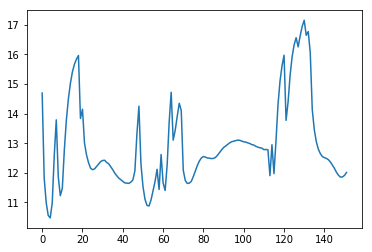

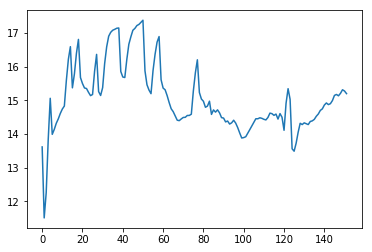

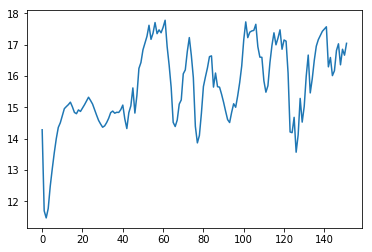

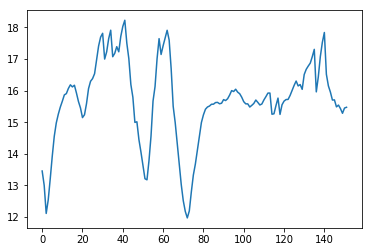

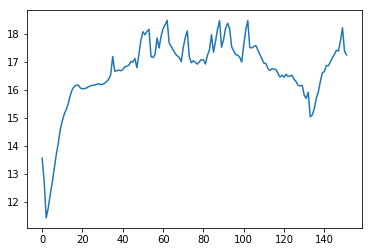

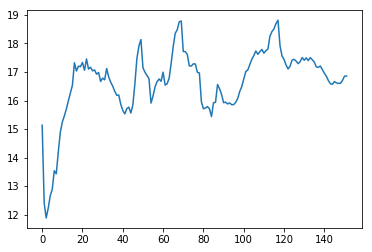

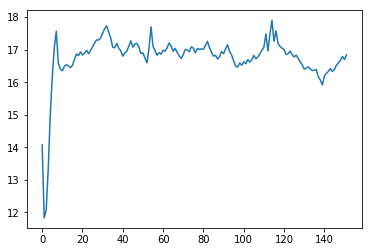

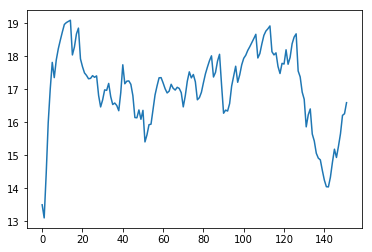

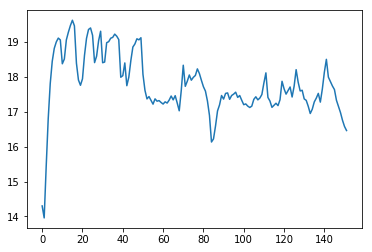

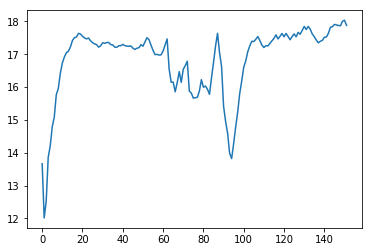

In [63]:
for trial in np.arange(0, 200, 20):
    game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)],  alpha = 0.5, input_type = 0)
    game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)))
    Pos,hs, dh, a, s, reward = trajectory(game, pos0 = (4, 2), epsilon=1, limit_set = 8)
    plt.figure()
    plt.plot([np.linalg.norm(h) for h in hs])
    print (np.mean([np.linalg.norm(h) for h in hs]))

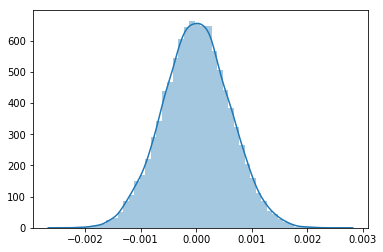

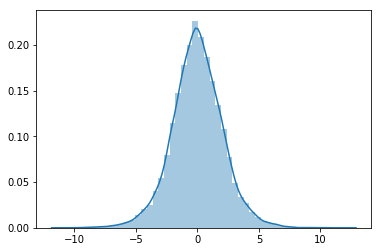

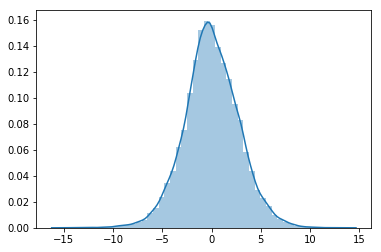

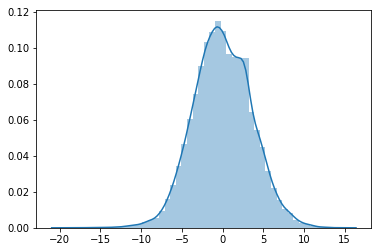

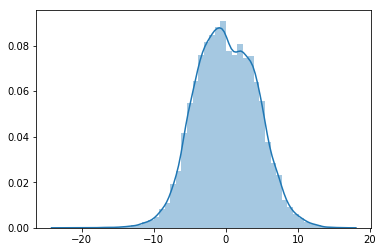

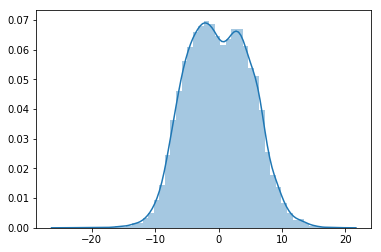

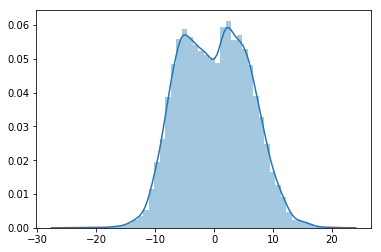

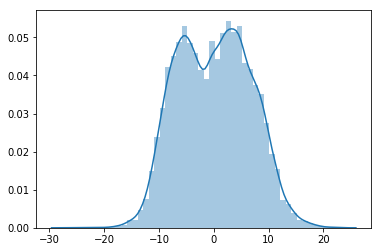

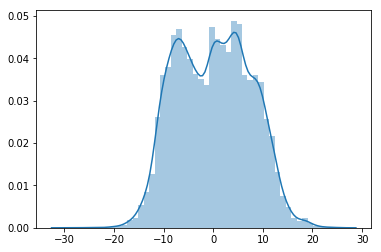

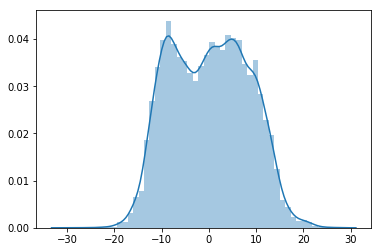

In [2]:
for trial in np.arange(0, 400, 40):
    game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)],  alpha = 0.5, input_type = 0)
    game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)))
    plt.figure()
    sns.distplot(game.net.state_dict()['h2p1'].data.numpy().ravel())

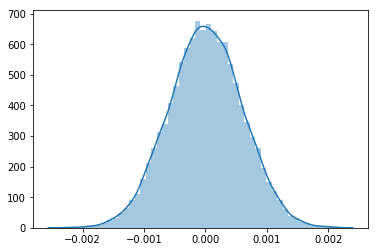

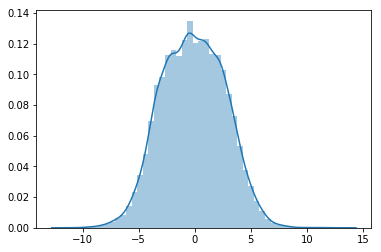

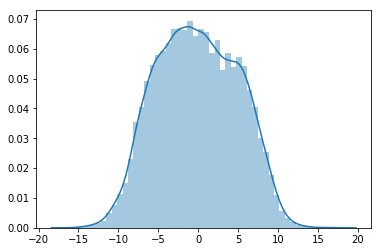

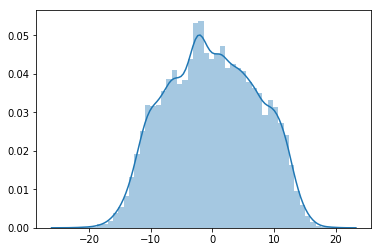

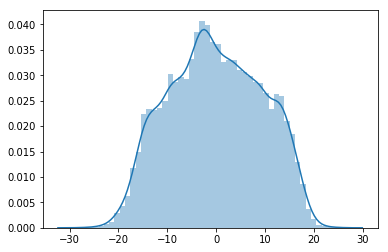

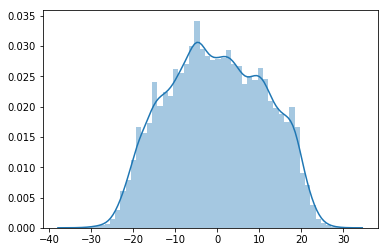

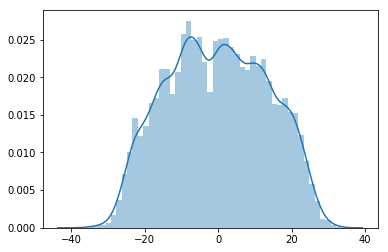

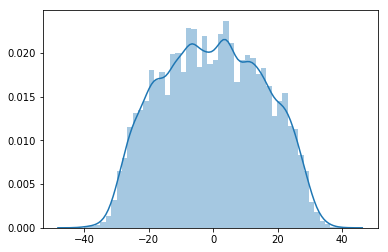

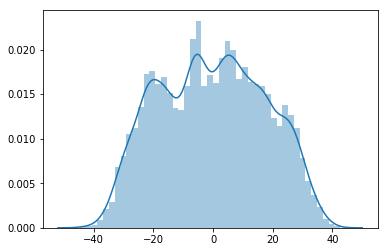

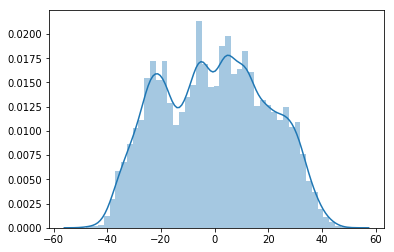

In [3]:
for trial in np.arange(0, 400, 40):
    game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)],  alpha = 0.5, input_type = 0)
    game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)))
    plt.figure()
    sns.distplot(game.net.state_dict()['h2p2'].data.numpy().ravel())

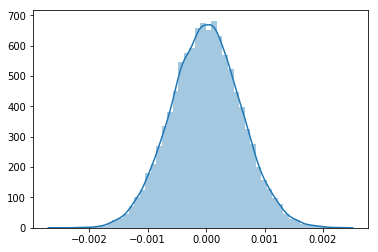

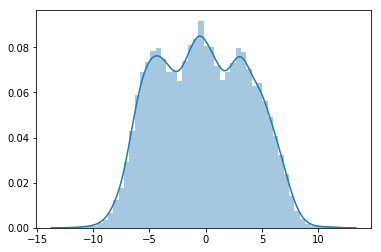

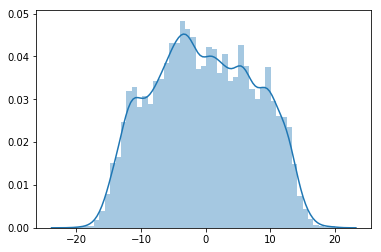

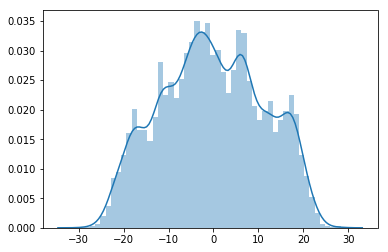

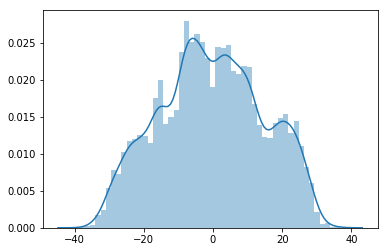

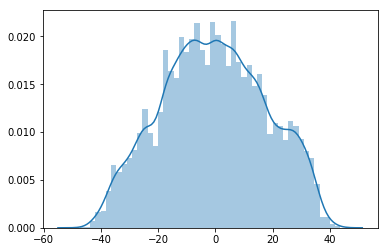

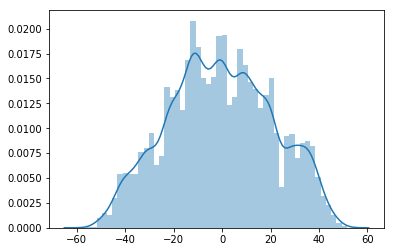

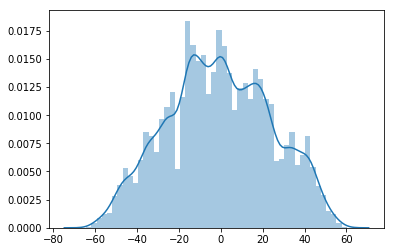

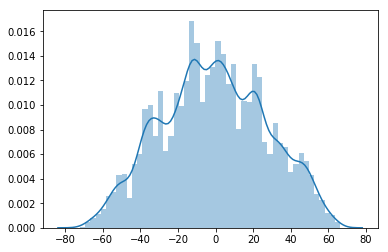

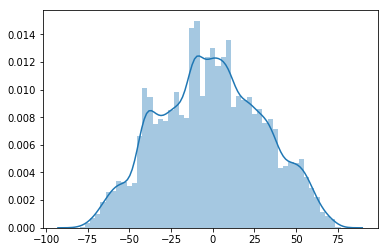

In [4]:
for trial in np.arange(0, 400, 40):
    game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)],  alpha = 0.5, input_type = 0)
    game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)))
    plt.figure()
    sns.distplot(game.net.state_dict()['h2p3'].data.numpy().ravel())

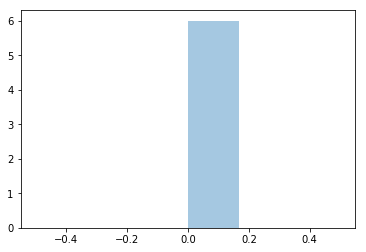

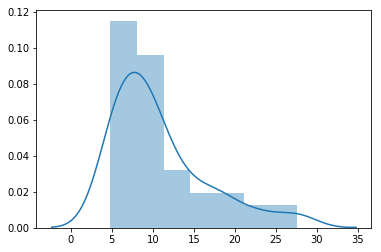

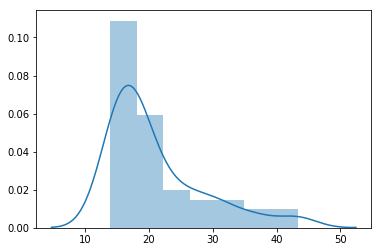

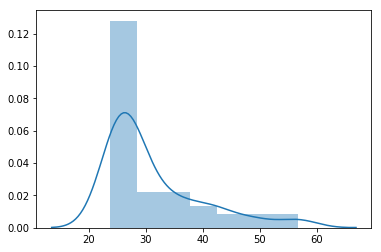

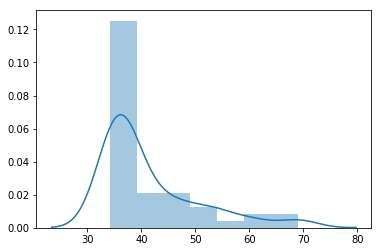

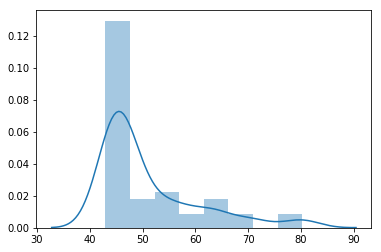

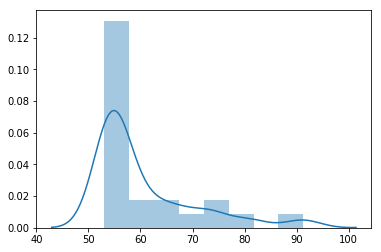

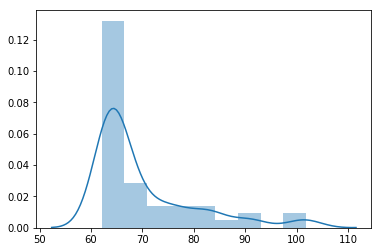

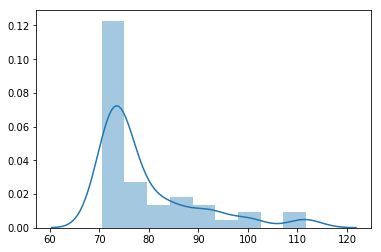

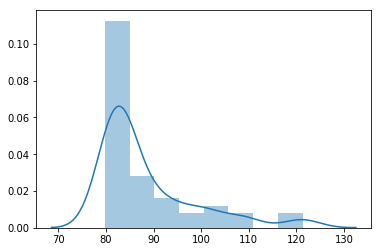

In [5]:
for trial in np.arange(0, 400, 40):
    game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)],  alpha = 0.5, input_type = 0)
    game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)))
    plt.figure()
    sns.distplot(game.net.state_dict()['bp3'].data.numpy().ravel())

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([ 10,  45,  59,  68, 169, 188, 208, 211, 279, 323, 373, 388, 396,
       439, 474, 505]),)
(array([], dtype=int64),)
(array([  0,   3,   4,  10,  14,  21,  32,  34,  49,  59,  82,  98, 107,
       117, 158, 164, 172, 174, 181, 182, 208, 209, 220, 223, 231, 235,
       238, 270, 278, 279, 285, 299, 302, 306, 313, 318, 322, 324, 341,
       343, 344, 354, 366, 371, 374, 413, 418, 434, 450, 452, 453, 456, 459]),)
(array([103]),)
(array([208, 277]),)
(array([104, 160, 165, 186, 188, 277, 333, 366, 421, 428, 485]),)


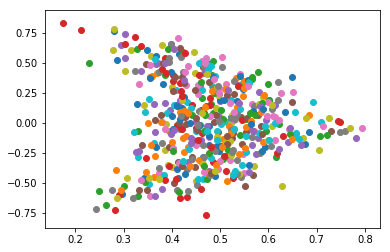

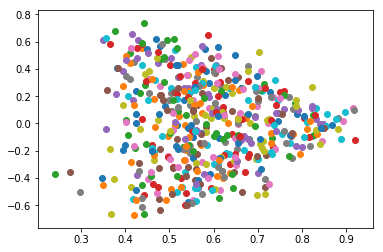

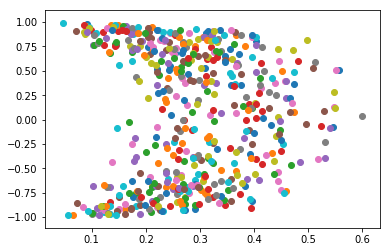

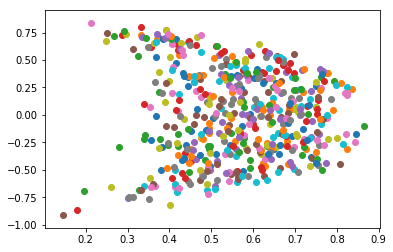

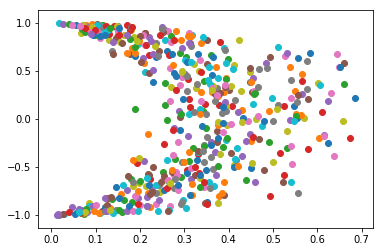

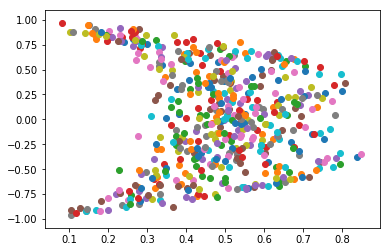

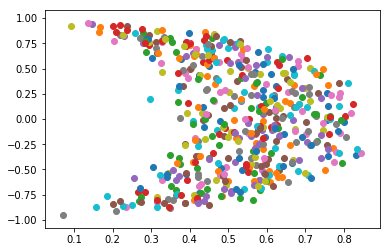

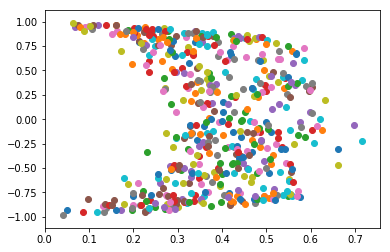

In [14]:
for trial in np.arange(0,160,20):
    game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)],  alpha = 0.5, input_type = 0)
    game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)))
    Pos,hs, dh, a, s, reward = trajectory(game, pos0 = (4, 2), epsilon=1, limit_set = 8)
    plt.figure()
    for i in range(512):
        plt.scatter(np.std(hs[:, i]), np.mean(hs[:, i]))
    print (np.where(np.std(hs, axis = 0)<0.1))

## Spectre

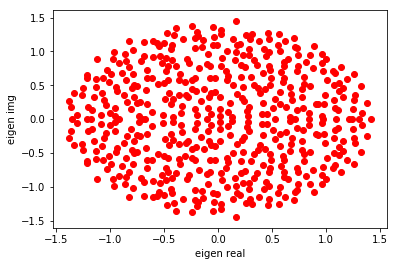

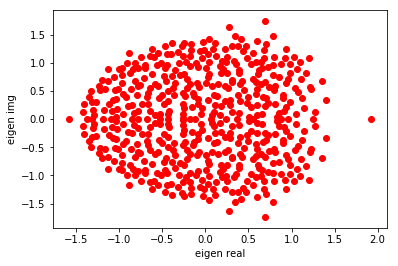

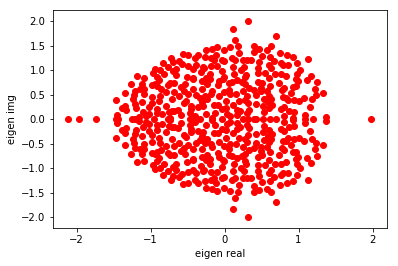

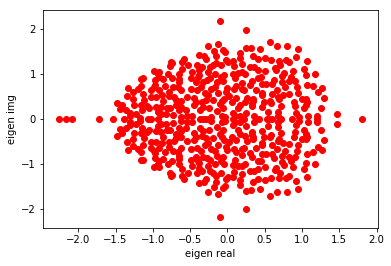

In [28]:
dWs = []
for iters, trial in enumerate(np.arange(0, 301, 100)):
    game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)],  alpha = 0.5, input_type = 0)
    game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)))
    game.net.h2o = nn.Parameter(torch.randn(512, 4) * 1 * np.sqrt(2.0/(512+4)))
    if iters == 0:
        W0 = game.net.h2h 
    W = game.net.h2h 
    dWs.append(W - W0)
    Weff = game.net.h2h + game.net.h2o.matmul(game.net.a2h)
    plt.figure()
    plt.scatter (W.eig()[0][:,0].data.numpy(), W.eig()[0][:,1].data.numpy(), label = trial, color = 'r')
#     plt.figure()
#     plt.scatter (Weff.eig()[0][:,0].data.numpy(), Weff.eig()[0][:,1].data.numpy(), label = trial, color = 'b')
    
#     plt.legend()
#     plt.xlim(-2, 2)
#     plt.ylim(-3, 3)

    plt.xlabel('eigen real')
    plt.ylabel('eigen img')
    plt.savefig('eigen{}'.format(trial))
#     print (Weff)

In [29]:
trial = np.arange(0, 301, 100)
for dW, trial in zip(dWs[1:], trial[1:]):
    dW = dW.data.numpy()
    dW_shuffle = np.random.permutation(dW.ravel()).reshape(512, 512)
    u, s, vh = np.linalg.svd(dW)
    u_shuffle, s_shuffle, vh_shuffle = np.linalg.svd(dW_shuffle)

    game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)))
    for i in range(4):
        wah0 = game.net.state_dict()['a2h'].data.numpy()[i] 
        theta1 = np.dot(wah0, vh[2])/(np.linalg.norm(vh[2]) * np.linalg.norm(wah0))
        theta2 = np.dot(wah0, u[2])/(np.linalg.norm(u[2]) * np.linalg.norm(wah0))
        theta3 = np.dot(u[2], vh[2])/(np.linalg.norm(u[2]) * np.linalg.norm(vh[2]))
        print (trial, theta1, theta2, theta3)

100 0.390879 -0.00775833 -0.0230338
100 -0.350959 -0.00495475 -0.0230338
100 -0.368603 0.0661997 -0.0230338
100 0.412384 0.0319959 -0.0230338
200 -0.181775 -0.0804341 0.0372348
200 0.324336 -0.00319426 0.0372348
200 0.225949 0.0447154 0.0372348
200 -0.271854 0.0162901 0.0372348
300 -0.0355017 0.0226062 0.0362271
300 0.188981 0.0746615 0.0362271
300 0.0940341 0.0427294 0.0362271
300 -0.128741 0.0033626 0.0362271


Text(0.5,1,'wah pre1')

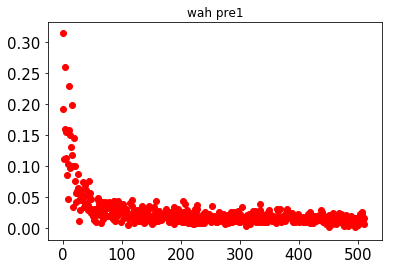

In [30]:
# ax = subplot(1, 1, 1)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
for r in np.arange(512):
    game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(300)))
    theta = 0
    for i in range(4):
        wah0 = game.net.state_dict()['a2h'].data.numpy()[i] 
        theta1 = np.dot(wah0, vh[r])/(np.linalg.norm(vh[r]) * np.linalg.norm(wah0))
        theta2 = np.dot(wah0, u[r])/(np.linalg.norm(u[r]) * np.linalg.norm(wah0))
        theta3 = np.dot(u[0], vh[r])/(np.linalg.norm(u[r]) * np.linalg.norm(vh[0]))
        theta += np.abs(theta1)
    plt.scatter(r, theta/4, color = 'r')
#         print (trial, theta1, theta2, theta3)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title('wah pre1')

Text(0.5,1,'wih pre1')

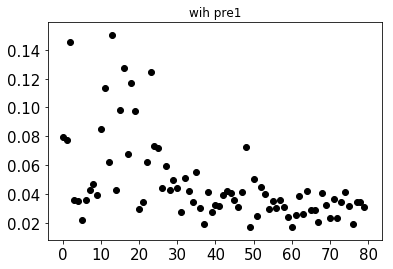

In [22]:
# ax = subplot(1, 1, 1)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
for r in np.arange(80):
    game.net.load_state_dict(torch.load('weights_cpu/rnn_1515tanh512_checkpoint{}'.format(300)))
    theta = np.zeros(9)
    for i in range(9):
        wah0 = game.net.state_dict()['i2h'].data.numpy()[i] 
        theta1 = np.dot(wah0, vh[r])/(np.linalg.norm(vh[r]) * np.linalg.norm(wah0))
        theta2 = np.dot(wah0, u[r])/(np.linalg.norm(u[r]) * np.linalg.norm(wah0))
        theta3 = np.dot(u[0], vh[r])/(np.linalg.norm(u[r]) * np.linalg.norm(vh[0]))
        theta [i] = np.abs(theta1)
    plt.scatter(r, np.mean(theta), color = 'k')
#         print (trial, theta1, theta2, theta3)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title('wih pre1')

If look carefully, the slow timescale here is a very long transient,  it will not return to baseline in a very long run of game, that is different from gru, which maintains a baseline.  If the system is a true integrator,  it should not loose the baseline, because there is no concept of return in this case. 

The very slow timescale could make the system harder to reset, except I use a strong input.  So reset upon input and remember is always contradictory.  If I design a task also need to pay attention to fast timescale , this will fail more throughly 

# Timescale, Spatial Information & Performance

**There is change associate with the pretraining, but if coupling all factors and use short stimlus pulses, there is no big effect**

**charaterize the system by timescale in this case, and input - output correlation with random action, use these two parameters to predict learning** 

**Another approach is the random readout compare,  the specific readout is related to one network, if we look at things statistically, something related to Whh will truly reveal.  The distribution also permits us to give continouse number as probability of bi-stability**

**Characterize the limit cycle by period and shape/complexity/dimension of wave**

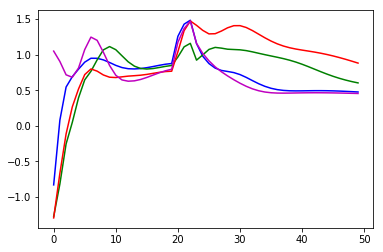

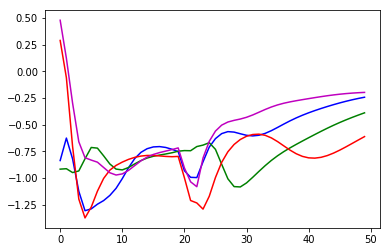

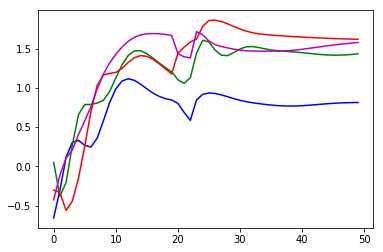

In [74]:
for i in range(268, 271):
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(i)
    pca = PCA(weight)
    pca.pca(T_duration = 5)
    pca.game.gain = 0.1
    context = pca.game.placefield((9, 6))
    pca.Dynamics(Actions = [0], legend = True, T_total =50, T_stim =20, T_duration = 3, \
                 readout_random = False, open_loop = True, context = context)
    # long dynamics for different stimulus
    colors = ['b', 'g', 'r', 'm', 'c']
    plt.figure()
    for i in range(4):
        for j in range(1):
            c = colors[i]
            plt.plot(pca.PCs[i, j], color = c)  

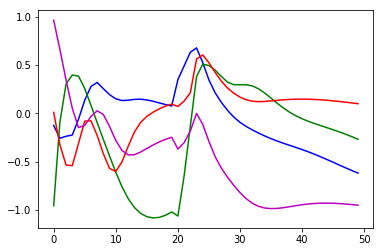

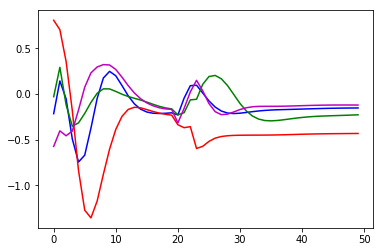

In [39]:
for i in range(240, 242):
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(i)
    pca = PCA(weight)
    pca.pca(T_duration = 5)
    pca.game.gain = 0.1
    context = pca.game.placefield((9, 6))
    pca.Dynamics(Actions = [0], legend = True, T_total =50, T_stim =20, T_duration = 3, \
                 readout_random = False, open_loop = True, context = context)
    # long dynamics for different stimulus
    colors = ['b', 'g', 'r', 'm', 'c']
    plt.figure()
    for i in range(4):
        for j in range(1):
            c = colors[i]
            plt.plot(pca.PCs[i, j], color = c)  

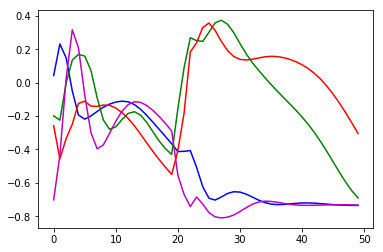

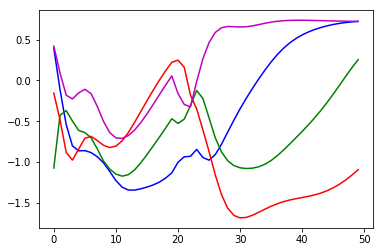

In [2]:
for i in range(300, 302):
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(i)
    pca = PCA(weight)
    pca.pca(T_duration = 5)
    pca.game.gain = 0.1
    context = pca.game.placefield((9, 6))
    pca.Dynamics(Actions = [0], legend = True, T_total =50, T_stim =20, T_duration = 3, \
                 readout_random = False, open_loop = True, context = context)
    # long dynamics for different stimulus
    colors = ['b', 'g', 'r', 'm', 'c']
    plt.figure()
    for i in range(4):
        for j in range(1):
            c = colors[i]
            plt.plot(pca.PCs[i, j], color = c)  

In [40]:
for i in range(240, 242):
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(i)
    Info_A, Info_I, Info_P = Memory(weight, k_action = 1, k_stim = 1, k_internal = 1, epsilon = 1, context_gain =1)
    print (Info_I)

0.00359258777337 0.111252153752 0.19845988994
[ 0.20793619  0.14652154  0.11355265  0.0986721   0.08997102  0.08340002
  0.07902051  0.07094319]
0.00528027953828 0.114984945027 0.249586715543
[ 0.27966282  0.17961043  0.1275874   0.09754212  0.07494862  0.06061726
  0.05284483  0.04706607]


In [75]:
for i in range(270, 272):
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(i)
    Info_A, Info_I, Info_P = Memory(weight, k_action = 1, k_stim = 1, k_internal = 1, epsilon = 1, context_gain =1)
    print (Info_I)

0.00493505710333 0.152222948441 0.202392665923
[ 0.26879487  0.22103227  0.17590467  0.15035506  0.12497558  0.10606365
  0.09189658  0.0787609 ]
0.00390331959992 0.141510585976 0.201703635868
[ 0.28059016  0.23068032  0.17510214  0.13389911  0.10428355  0.08201929
  0.06904923  0.05646089]


In [98]:
for i in range(300, 302):
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(i)
    Info_A, Info_I, Info_P = Memory(weight, k_action = 1, k_stim = 1, k_internal = 1, epsilon = 1, context_gain =1)
    print (Info_I)

0.00401941463355 0.143619246206 0.241519813308
[ 0.28156884  0.23252155  0.17156794  0.13090115  0.10672754  0.0881687
  0.07412084  0.06337742]
0.0045640745585 0.209057559742 0.24842383187
[ 0.33300248  0.29455858  0.25045958  0.2088597   0.17731414  0.15464258
  0.13579732  0.1178261 ]


In [7]:
for i in range(350, 351):
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(i)
    Info_A, Info_I, Info_P = Memory(weight, k_action = 1, k_stim = 1, k_internal = 1, epsilon = 1, context_gain =1)
    print (Info_I)

0.00423414300718 0.175707821548 0.200672547185
[ 0.31543965  0.28271846  0.22428782  0.17213538  0.13264326  0.10799478
  0.09109669  0.07934652]


## Decoding

In [12]:
for trial in [0]: 
    size = 15
    Pretest =  PretrainTest(holes = 0, weight_write =  'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial), inputs_type=(0, 0))        
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)
    Prec0, prec_matrix0 = Pretest.decode(weight = weight, size_range = [size], size_test = [size], epsilon = 1)
    np.save('Dist{}'.format(trial), prec_matrix0)

KeyboardInterrupt: 

Text(0.5,0,'accuracy')

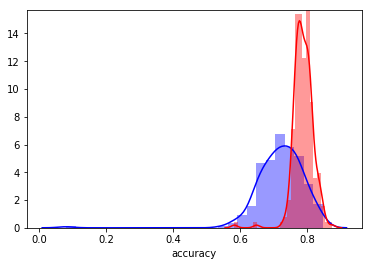

In [17]:
sns.distplot(1 - prec_matrix0.ravel()/15., color = 'b')
sns.distplot(1 - prec_matrix3.ravel()/15, color = 'r')
plt.xlabel('accuracy')

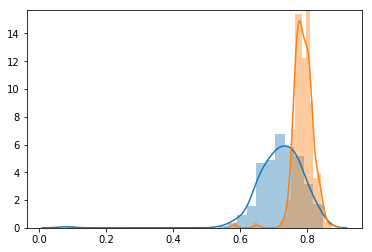

In [11]:
sns.distplot(1 - prec_matrix0.ravel()/15)
sns.distplot(1 - prec_matrix3.ravel()/15)

In [ ]:
for trial in [100]: 
    size = 15
    Pretest =  PretrainTest(holes = 0, weight_write =  'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial), inputs_type=(0, 0))        
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)
    Prec, prec_matrix = Pretest.decode(weight = weight, size_range = [size], size_test = [size], epsilon = 1)
    np.save('Dist{}'.format(trial), prec_matrix)

-1.2583233754344303

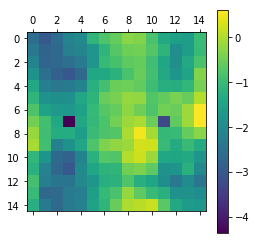

In [12]:
plt.matshow(prec_matrix - prec_matrix0)
plt.colorbar()
np.mean(prec_matrix - prec_matrix0)

In [10]:
# Not distinguish the context, then train decoder, ** the middle increase of decoding error reflects appearence of context separation**

for trial in [200]: 
    size = 15
    Pretest =  PretrainTest(holes = 0, weight_write =  'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial), inputs_type=(0, 0))        
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)
    Prec, prec_matrix = Pretest.decode(weight = weight, size_range = [size], size_test = [size], epsilon = 1)
    np.save('Dist{}'.format(trial), prec_matrix)

clear session data 49 2377691136
0 3.11454423924
clear session data 49 2377641984
1 3.37589635441
decode train finish 3.24522029683


In [9]:
for trial in [300]: 
    size = 15
    Pretest =  PretrainTest(holes = 0, weight_write =  'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial), inputs_type=(0, 0))        
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)
    Prec3, prec_matrix3 = Pretest.decode(weight = weight, size_range = [size], size_test = [size], epsilon = 1)
    np.save('Dist{}'.format(trial), prec_matrix)

clear session data 49 2378612736
0 2.89340377028
clear session data 49 2378977280
1 3.45684939845
decode train finish 3.17512658437


NameError: name 'prec_matrix' is not defined

In [10]:
 np.save('Dist{}'.format(trial), prec_matrix3)

0.061106467439978662

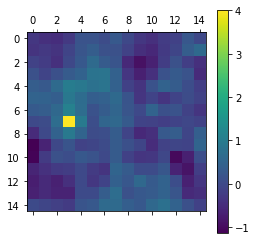

In [16]:
plt.matshow(prec_matrix3 - prec_matrix)
plt.colorbar()
np.mean(prec_matrix3 - prec_matrix)

In [12]:
for trial in [359]: 
    size = 15
    Pretest =  PretrainTest(holes = 0, weight_write =  'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial), inputs_type=(0, 0))        
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)
    Prec, prec_matrix = Pretest.decode(weight = weight, size_range = [size], size_test = [size], epsilon = 1)
    np.save('Dist{}'.format(trial), prec_matrix)

clear session data 49 2377641984
0 2.63301043751
clear session data 49 2377641984
1 3.67791863292
decode train finish 3.15546453522


In [30]:
for trial in [399]: 
    size = 15
    Pretest =  PretrainTest(holes = 0, weight_write =  'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial), inputs_type=(0, 0))        
    weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)
    Prec4, prec_matrix4 = Pretest.decode(weight = weight, size_range = [size], size_test = [size], epsilon = 1)
    np.save('Dist{}'.format(trial), prec_matrix)

clear session data 49 2393829376
0 2.86177376697
clear session data 49 2398154752
1 3.28660322884
decode train finish 3.07418849791


NameError: name 'prec_matrix' is not defined

0.079249917670852973

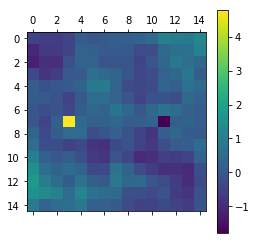

In [14]:
plt.matshow(prec_matrix4 - prec_matrix)
plt.colorbar()
np.mean(prec_matrix4 - prec_matrix)

**If increasing gain of action, then directions will be strongly represented, good for obstacles tasks**

### Summary

**0 The strategy is directly reflecting the internal dynamics**

**1 The ability to model the external world lies in richness of internal dynamics, for example the distribution of timescales forms during the pretraining**

**2 To characterize the rich internal timescales , there are 5 features, 1,  the ratio limit cycle/fix point 2,  the mean of relaxation time to fix point 3, the variance of relaxation timescale to fix point  4, the distribution of timescales of limit cycles 5,  The multi-stablity from stimulus**

**3 The performance are : extrapolation performance(small, large),  intrapolation performance(small , middle , large),  learning speed, learning stability,  Try to to connect the 5 features of dynamics to the performance metrix**

**4, Until now ratio limit cycle/fix point during the close loop form seems to indicates best the performance but with noise.**  


**what is the relation between close loop and open loop analysis?**

longer time, there is no pheonmean associate with multi-stability

Here with action feedback, dynamics shift to a totally different regime which is around hopf bifurcation, but it is not hugely shaped by the stimulus

From this graph of PC, we will see that the representation states of trajectory (3,5) and (14,5) are actually qutie close to each other , reflecting symmetry in real space, it is in spirit of predictive decoding, using least number of interal states to play well. 

# Conclusion
**Internal dynamics rather than decoding performance influences more the performance in uncertain enviroments**

**Consider to think in global loops rather than separated system, thus the coupled dynamical system.  This system, which has its genome on its internal weights, will have quite different different pheno-types from the global loops,  richness of internal dynamics turns into extenable phenotypes which supports behaviours across scales.   The different types of attractors, fix point, limit cycle becomes substrate of strategy in different size rooms.  Thus generalization can be done until certain size, which offers complicate behaviour with a "simple mind"**

**The triangle between decoding, dynamics and navigation should be like: 1, dynamics coded by internal weight is most fundamental, it gives rise to different representations(phenotypes).   2,  The relation between decoding and navigation are reciprocal. not random behaviour gives better enviromental prediction(complement the free energy principle) 2,  we should distinguish internal dynamics and global dynamics**